In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

## Standard VAE + Bedford VAE

In [2]:
abspath = "./VAE_standard"

In [3]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
from treetime.utils import datetime_from_numeric
import pymc as pm
from collections.abc import Iterable
import altair as alt

import pickle
import cloudpickle
import arviz as az

In [4]:
BATCH_SIZE = 64
# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/../data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load(f"{abspath}/bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load(f"{abspath}/model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [7]:
dset = ["training", "valid", "test"]
dset = dset[0]
print(dset)
abspath = "."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

training


In [8]:
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, float)):
            yield from flatten(x)
        else:
            yield x

collection_dates = pd.DataFrame([[x] for i,x in enumerate(dates)], columns=["date"])
collection_dates.index = pd.to_datetime(collection_dates["date"])
collection_dates = collection_dates.groupby(pd.Grouper(freq='W'))
collection_dates = list(collection_dates.groups.values())
print(collection_dates)
collection_dates = [collection_dates[0]] + [collection_dates[i] - collection_dates[i-1] for i in range(len(collection_dates)-1, 0, -1)][::-1]
collection_dates = list(flatten([[i for j in range(x)] for i,x in enumerate(collection_dates)]))

[3, 14, 15, 18, 30, 35, 38, 46, 54, 57, 62, 63, 65, 70, 73, 78, 83, 90, 93, 97, 102, 106, 115, 121, 122, 133, 142, 146, 148, 151, 154, 167, 175, 181, 187, 193, 198, 200, 201, 210, 212, 216, 218, 222, 225, 230, 235, 240, 243, 247, 248, 253, 258, 260, 260, 264, 267, 268, 270, 270, 275, 278, 278, 281, 281, 284, 285, 287, 287, 289, 290, 290, 290, 290, 291, 294, 299, 305, 310, 314, 319, 325, 333, 336, 336, 339, 343, 345, 346, 351, 357, 358, 361, 363, 366, 369, 372, 375, 376, 376, 382, 383, 385, 386, 386, 389, 396, 397, 397, 399, 403, 404, 408, 409, 412, 414, 415, 417, 419, 419, 425, 426, 431, 432, 432, 435, 435, 436, 439, 442, 467, 475, 489, 602, 743, 831, 961, 1103, 1234, 1397, 1524, 2030, 2517, 2860, 3239, 3528, 3758, 4033, 4252, 4555, 4816, 5018, 5361, 5558, 5817, 6057, 6274, 6368]


In [9]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'22B (BA.5)', '19A', '23I (BA.2.86)', '21K (BA.1)', '22F (XBB)', '24D (XDV.1)', '23A (XBB.1.5)', '24I (MV.1)', '24E (KP.3.1.1)', '23B (XBB.1.16)', '23D (XBB.1.9)', '22A (BA.4)', '24A (JN.1)', '23F (EG.5.1)', '25B (NB.1.8.1)', '25C (XFG)', '24H (LF.7)', '24F (XEC)', '22C (BA.2.12.1)', '25A (LP.8.1)', '22D (BA.2.75)', '21L (BA.2)'}


In [10]:
# print(set(clade_labels))

# clusters = np.sort(np.array(list(set(good_clade_labels))))
clusters = np.sort(np.array(list(set(clade_labels))))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']


In [11]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [12]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])

Recon shape
torch.Size([6368, 19110])
[0.45191533 0.33159555 0.19805563]
total variance: 0.9815665069351586


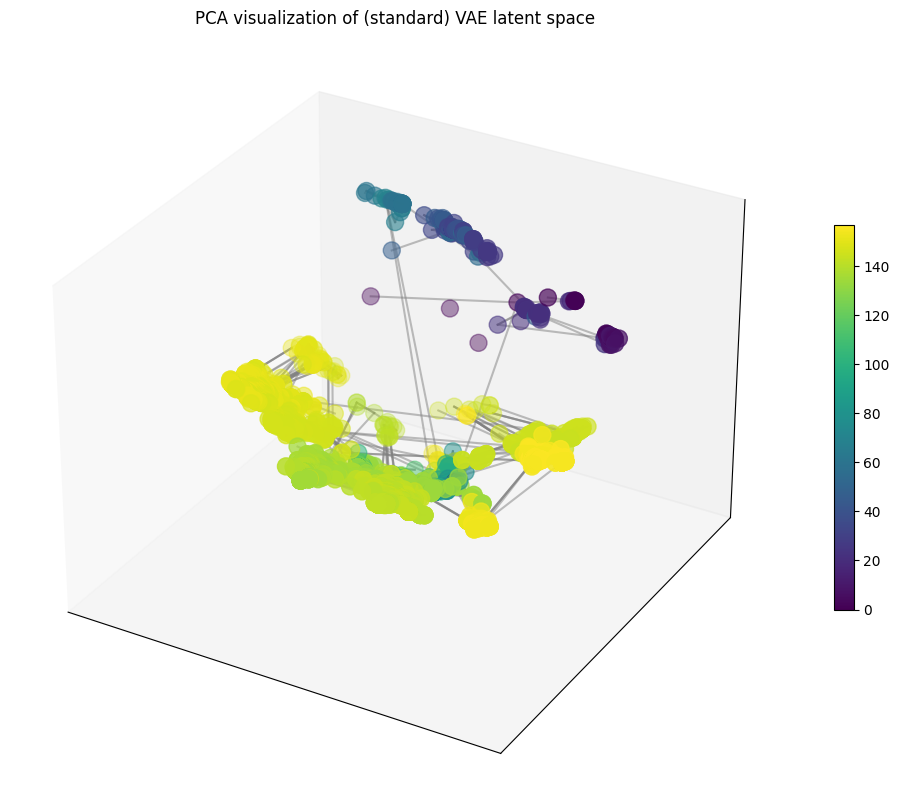

In [13]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=3, svd_solver="full")


recon = None
Z_mean = None
Z_embedded = None
scatterplot = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()
    
    print("\nRecon shape")
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - torch.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    

# %matplotlib widget
# plt.ion()
fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))

# RELATIONS
# for i,arr in enumerate(indexes):
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

# TIME 
scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
fig.colorbar(scatterplot, ax=ax, shrink=0.5)

ax.set_title("PCA visualization of (standard) VAE latent space")
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()


In [14]:
print(pca.components_.shape)
print(pca.singular_values_)

(3, 50)
[136.81514595 117.19524374  90.57309999]


In [ ]:
genome = X.view(X.shape[0], -1, len(ALPHABET)).cpu().numpy().astype("int")
genome = np.matmul(genome, np.arange(len(ALPHABET)))

In [ ]:
from collections.abc import Iterable
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, float)):
            yield from flatten(x)
        else:
            yield x

In [ ]:
N = Z_embedded.shape[0]
print(N)
hamming = list(flatten([np.sum(np.not_equal(genome[i,:],genome[(i+1):,:]),axis=-1) for i in range(N-1)]))
euclid = list(flatten([np.linalg.norm((Z_embedded[(i+1):,:] - Z_embedded[i,:]), axis=-1) for i in range(N-1)]))

fig,arr = plt.subplots(1,1,figsize=(14,10))
arr.set_title("Hamming vs. Euclidean dist")
arr.scatter(hamming, euclid, alpha=0.3)
plt.show()

## GP regression, sampling by month

In [14]:
print(metadata.columns)

Index(['name', 'parent', 'date', 'clade_membership', 'S1_mutations'], dtype='object')


In [15]:
X = torch.tensor(new_dataset[ranges,:,:])
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
print("X shape")
print(new_dataset.shape)
print(X.shape)

pca = PCA(n_components=3, svd_solver="full")

Z_mean = None
Z_embedded = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()

    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - torch.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print("\n",variances)
    print(f"total variance: {tot}")

X shape
(6368, 3822, 5)
torch.Size([6368, 19110])

 [0.45191533 0.33159555 0.19805563]
total variance: 0.9815665069351586


In [16]:
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

coords = [(x1,x2,x3,t,c) for (x1,x2,x3),t,c in zip(Z_embedded, dates,clade_labels)]
coords = pd.DataFrame(data=coords, columns=["dim0","dim1","dim2","time","clade"])

In [17]:
# sample by month 
avg_coords = coords.groupby("time")[["dim0","dim1","dim2"]].median().resample("ME").median().dropna().reset_index()

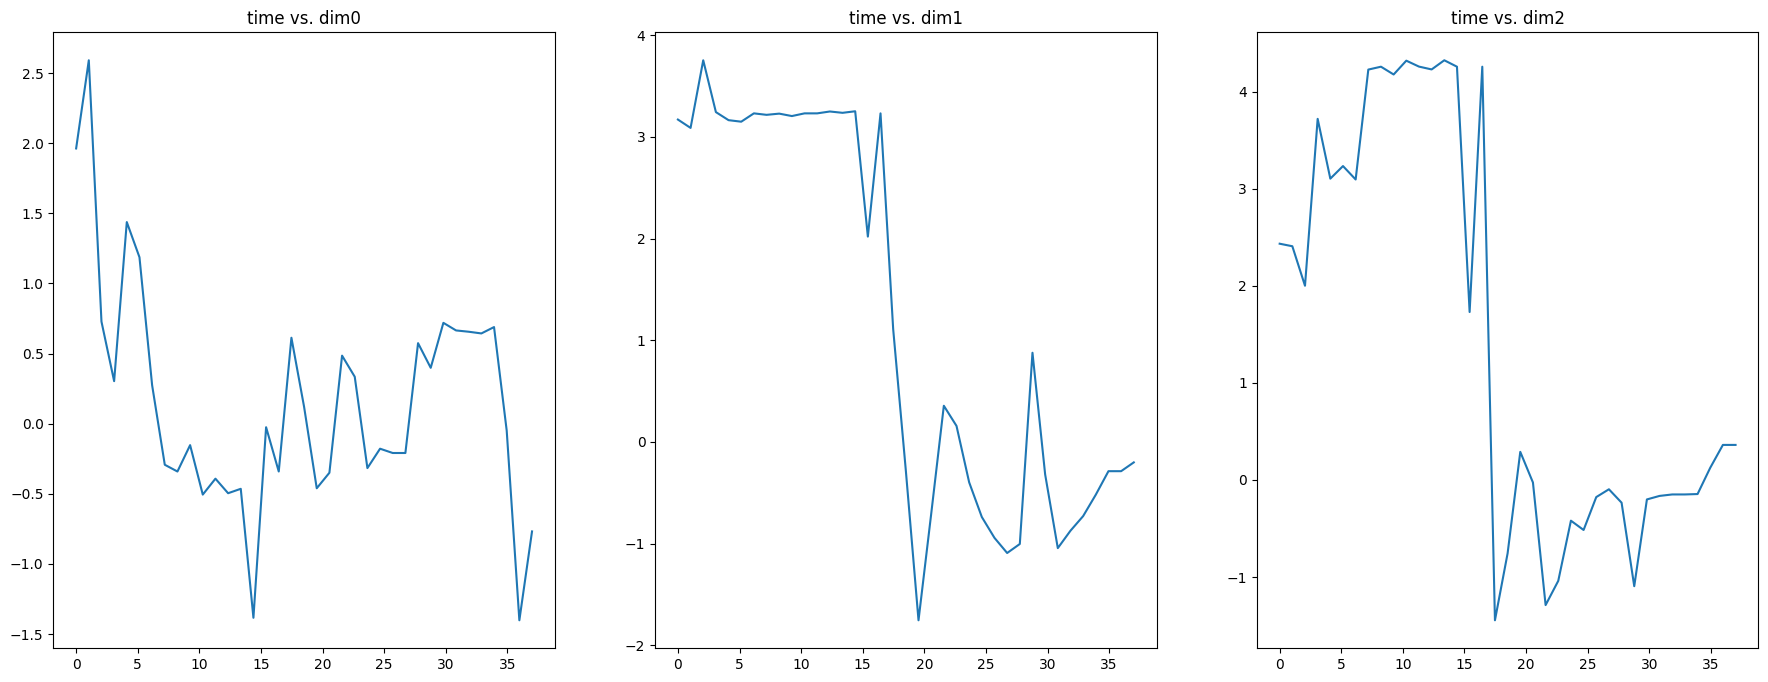

In [18]:
ubound = len(avg_coords)

plt.ioff()
fig,ax = plt.subplots(1,3,figsize=(22,8))
for i,d in enumerate(["dim0","dim1","dim2"]):
    ax[i].plot(np.linspace(0,ubound,num=len(avg_coords)), avg_coords[d])
    ax[i].set_title(f"time vs. {d}")
plt.show()

In [19]:
x_vals = np.linspace(0,ubound,num=len(avg_coords)).astype("float32")[:,np.newaxis]
# import theano.tensor as tt
def build_coords_model(dim, num_draws=2000):
    y_vals = avg_coords[dim].values.astype('float32')
    print(x_vals.shape, y_vals.shape)

    model = None
    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', np.exp(log_s2_f))
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        # Sigma = 1/lam
        s2_n = pm.HalfCauchy('s2_n', beta=5)

        gp = pm.gp.Latent(cov_func=f_cov)
        f = gp.prior("f",X=x_vals)

        df = 1 + pm.Gamma("df",alpha=2,beta=1)
        y_obs = pm.StudentT("y", mu=f, lam=1.0 / s2_n, nu=df, observed=y_vals)

        trace = pm.sample(draws=num_draws)
    return trace, gp, model

### Run and save regresssion

In [ ]:
# ls = ["dim0"]
# # ls = ["dim0","dim1","dim2"]

# ret_vals = [build_coords_model(d, num_draws=2000) for d in ls]

# GPs = [x[1] for x in ret_vals]
# idata = [x[0] for x in ret_vals]
# models = [x[2] for x in ret_vals]

# abspath = "."
# dict_to_save = {x:(idata[i],GPs[i]) for i,x in enumerate(["dim0","dim1","dim2"])}
# with open(f"{abspath}/king_regression_data.pkl","wb") as buff:
#     cloudpickle.dump(dict_to_save, buff)

In [21]:
for n,d in zip(ls,idata):
    print(n)
    n_nonconverged = int(
        np.sum(az.rhat(d)[["l", "log_s2_f", "s2_n", "f_rotated_", "df"]].to_array() > 1.03).values
    )
    if n_nonconverged == 0:
        print("No Rhat values above 1.03, \N{check mark}")
    else:
        print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

dim0
No Rhat values above 1.03, ✓
dim1
No Rhat values above 1.03, ✓
dim2
No Rhat values above 1.03, ✓


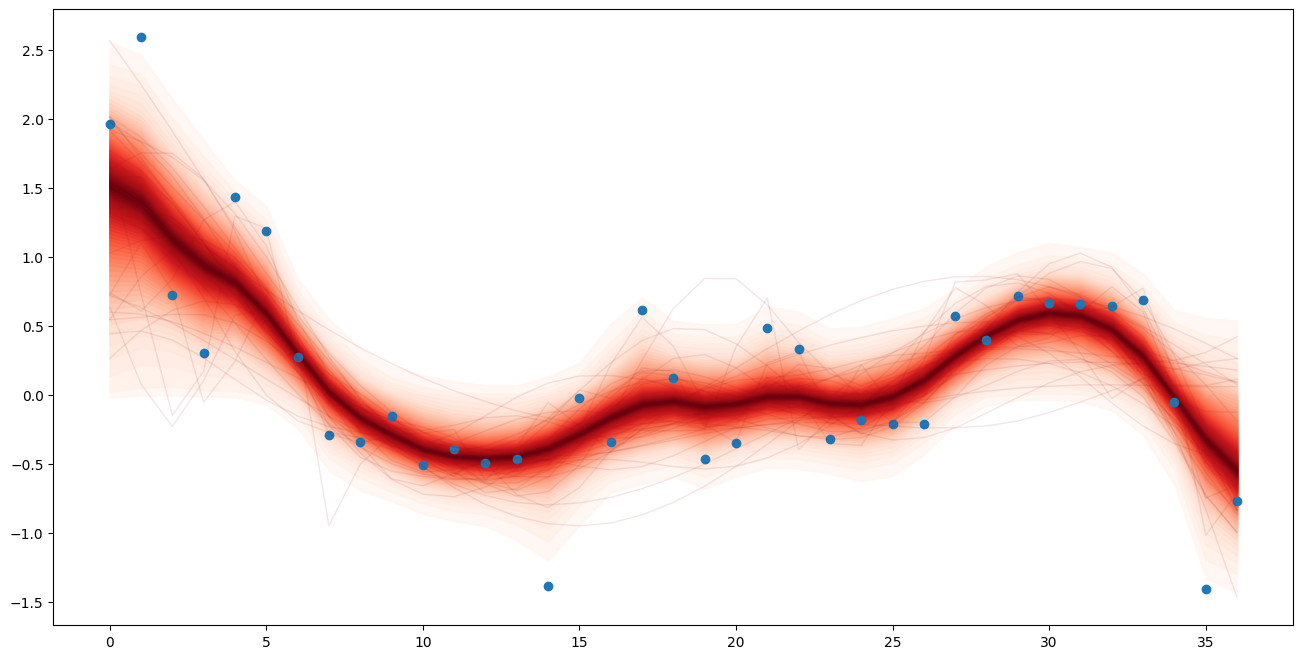

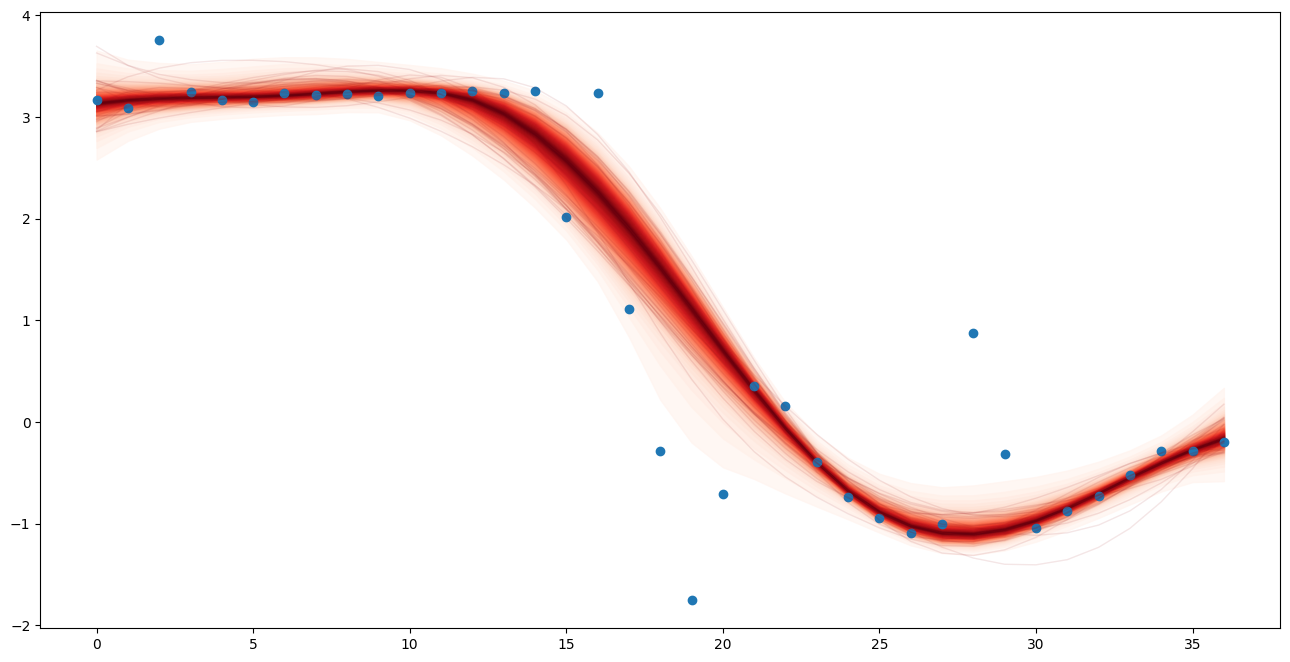

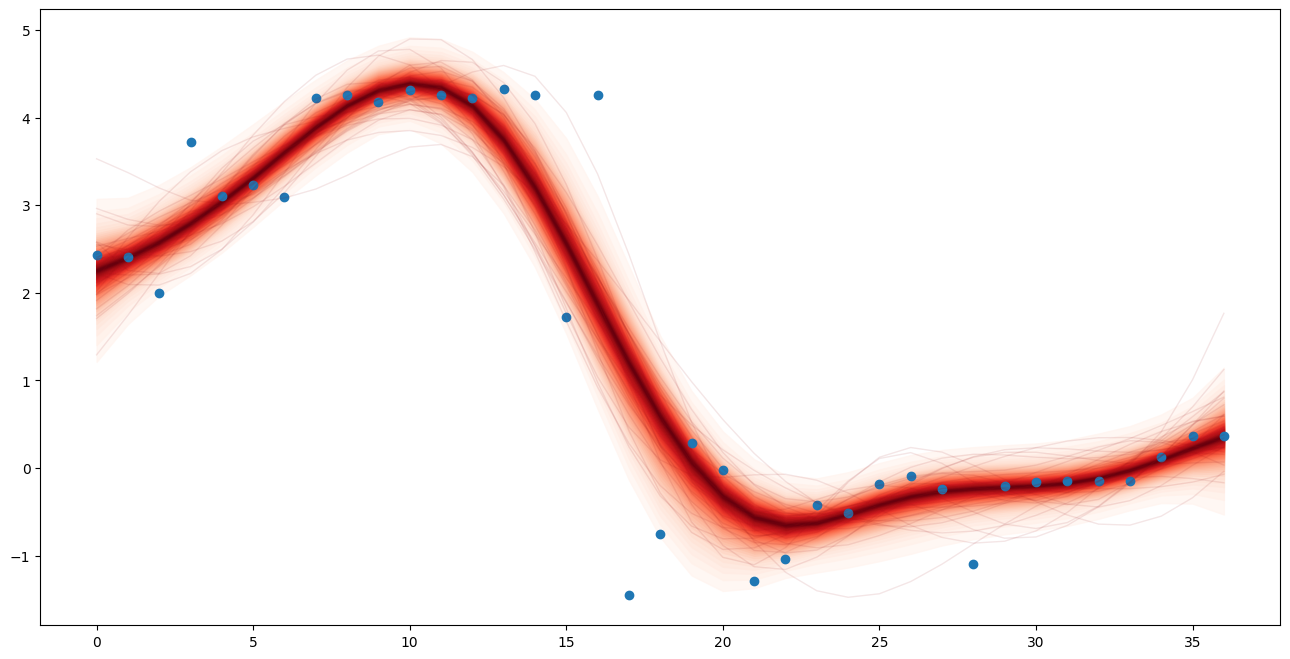

In [20]:
# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

ls = ["dim0"]

idata = None
GPs = None
models = None
ls = ["dim0","dim1","dim2"]
with open (f"{abspath}/king_regression_data.pkl", "rb") as buff:
    ret_vals = pickle.load(buff)
    idata = [ret_vals[x][0] for x in ls]
    GPs = [ret_vals[x][1] for x in ls]
    models = [ret_vals[x][2] for x in ls]

for d,n in zip(idata,ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    disp_x_vals = np.arange(len(avg_coords))
    
    f_post = az.extract(d, var_names="f").transpose("sample", ...)
    ax = plot_gp_dist(ax, f_post, disp_x_vals)
    ax.scatter(disp_x_vals, avg_coords[n])
    plt.show()

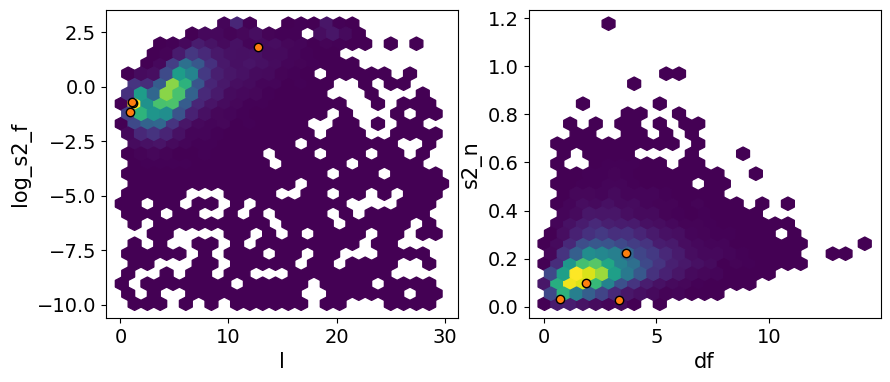

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

N = 0

# plot eta vs ell
az.plot_pair(
    idata[N],
    var_names=["l", "log_s2_f"],
    kind=["hexbin"],
    ax=axs[0],
    gridsize=25,
    divergences=True,
)
# axs[0].axvline(x=eta_true, color="dodgerblue")
# axs[0].axhline(y=ell_true, color="dodgerblue")

# plot nu vs sigma
az.plot_pair(
    idata[N],
    var_names=["df", "s2_n"],
    kind=["hexbin"],
    ax=axs[1],
    gridsize=25,
    divergences=True,
)

# axs[1].axvline(x=nu_true, color="dodgerblue")
# axs[1].axhline(y=sigma_true, color="dodgerblue");

plt.show()

In [21]:
ubound = len(avg_coords)
new_x_vals = np.linspace(-5,ubound,num=50).astype("float32")[:,np.newaxis]
x_vals = np.linspace(0,ubound,num=len(avg_coords)).astype("float32")[:,np.newaxis]
ls = ["dim0","dim1","dim2"]

pred_data = []
for N in range(len(ls)):
    print(ls[N])
    gp = GPs[N]
    dim_data = idata[N]
    with models[N]:
        # add the GP conditional to the model, given the new X values
        f_pred = gp.conditional("f_pred", new_x_vals, jitter=1e-4)
        # Sample from the GP conditional distribution
        dim_data.extend(pm.sample_posterior_predictive(dim_data, var_names=["f_pred"]))
        pred_data.append(dim_data)

dim0


Sampling: [f_pred]


dim1


Sampling: [f_pred]


dim2


Sampling: [f_pred]


['dim0', 'dim1', 'dim2']
(24000, 50)


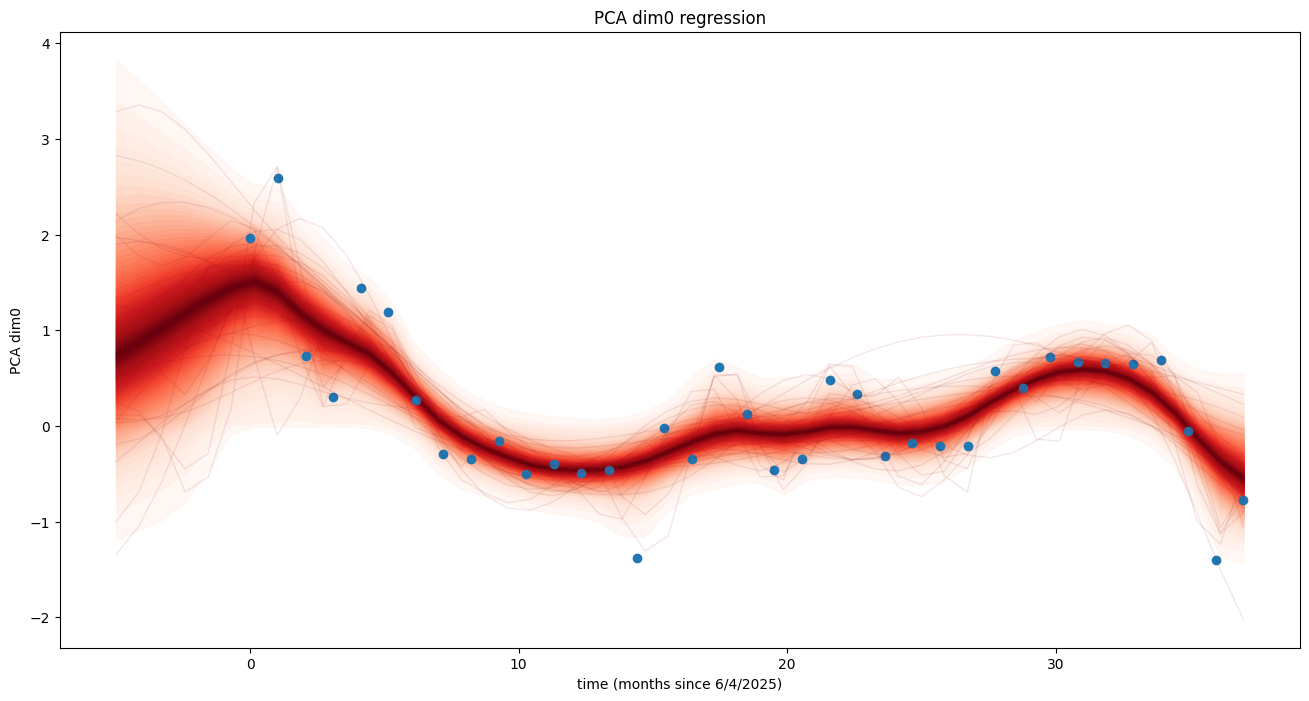

(24000, 50)


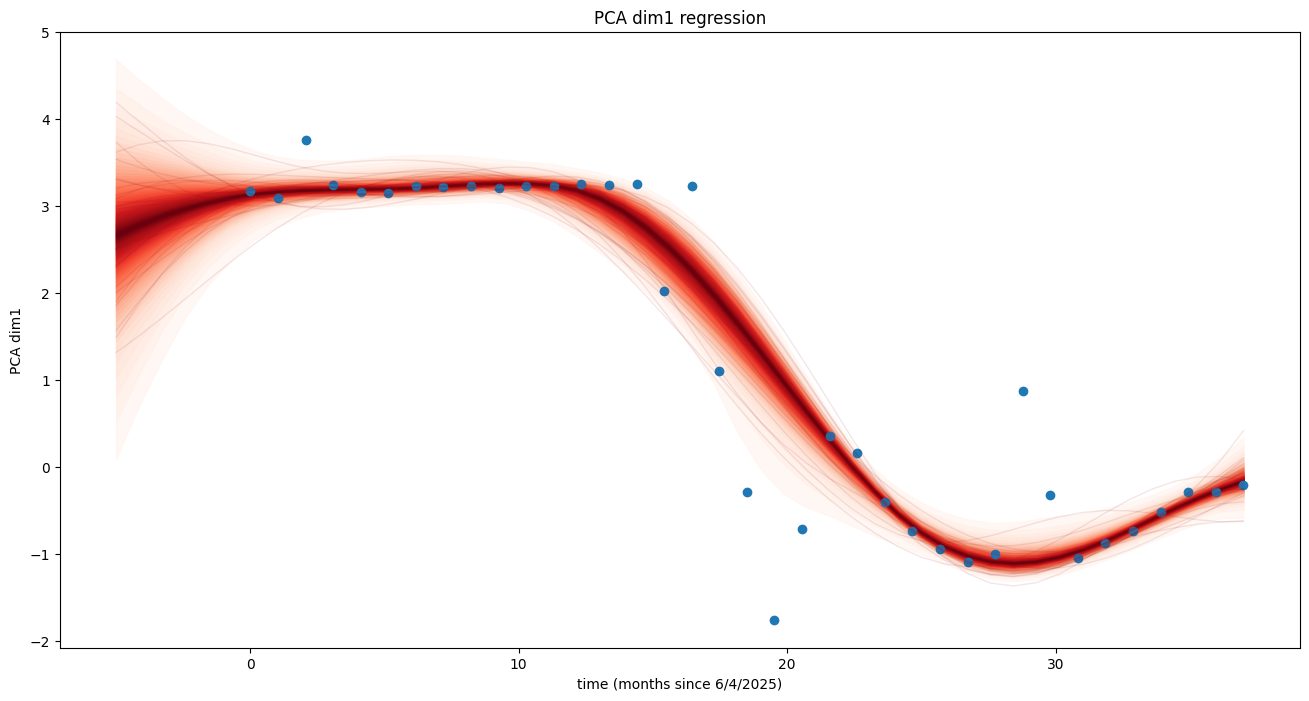

(24000, 50)


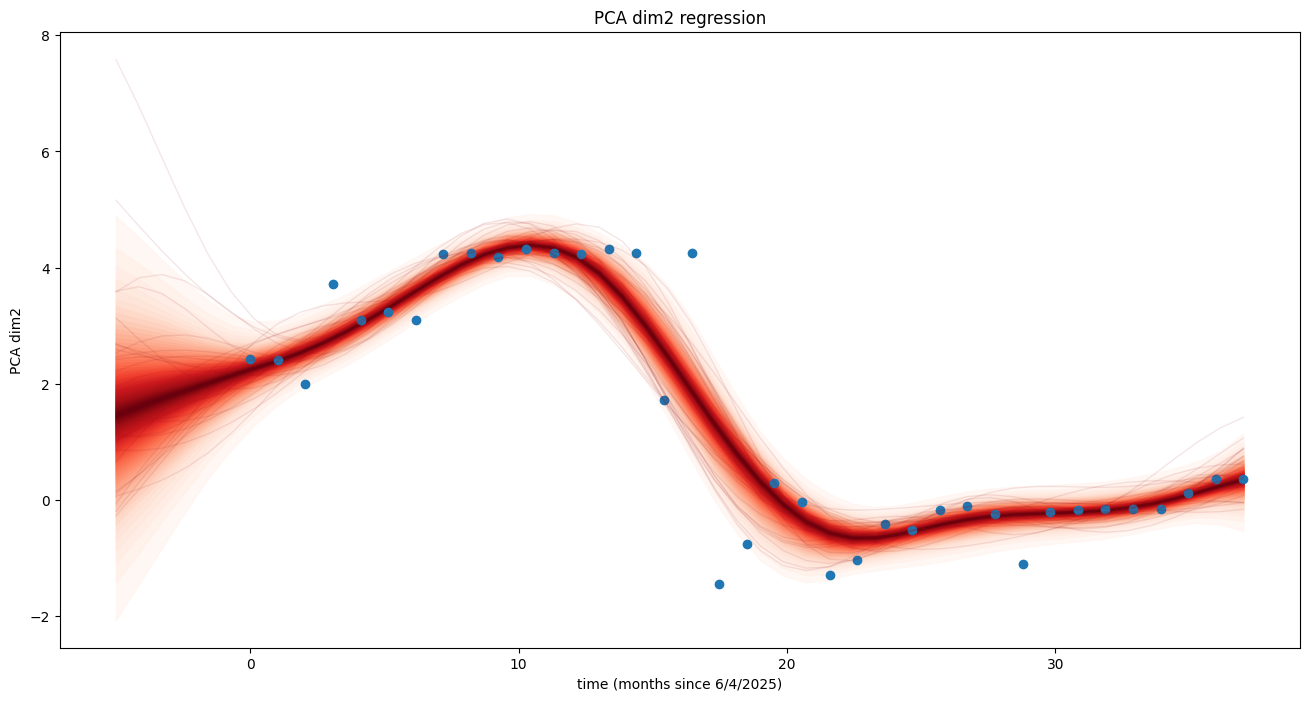

In [37]:
reg_preds = []
print(ls)
for i,n in enumerate(ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)
    reg_preds.append(f_pred)
    
    # plot_gp_dist(ax, f_post, x_vals, palette="Reds")
    ax = plot_gp_dist(ax, f_pred, new_x_vals, palette="Reds")
    ax.set_title(f"PCA {n} regression")
    ax.set_xlabel("time (months since 6/4/2025)")
    ax.set_ylabel(f"PCA {n}")
    ax.scatter(x_vals, avg_coords[n])
    plt.show()

reg_preds = np.array(reg_preds)

## Decode into SPIKE sequences and save FASTA

In [23]:
N_seq_predict = 50

In [90]:
pred_range = (new_x_vals < 0)[:,0]
Z_regression_pred = np.copy(reg_preds)
Z_regression_pred = Z_regression_pred[:,:,pred_range]

Z_regression_pred = np.moveaxis(Z_regression_pred, 1, -1)
Z_regression_pred = np.concatenate([np.quantile(Z_regression_pred, a, axis=-1, keepdims=True) for a in [0.25,0.5,0.75]], axis=-1)

# sample = np.random.choice(Z_regression_pred.shape[-1], N_seq_predict, replace=False) # randomly sample 1000 seq.
# Z_regression_pred = Z_regression_pred[:,:,sample]
sampled_seqs = np.copy(Z_regression_pred)
Z_regression_pred = np.moveaxis(Z_regression_pred, 0, -1)

Z_regression_pred = pca.inverse_transform(Z_regression_pred) + np.mean(Z_mean.cpu().numpy())
old_shape = Z_regression_pred.shape
Z_regression_pred = Z_regression_pred.reshape((Z_regression_pred.shape[0] * Z_regression_pred.shape[1], Z_regression_pred.shape[2]))

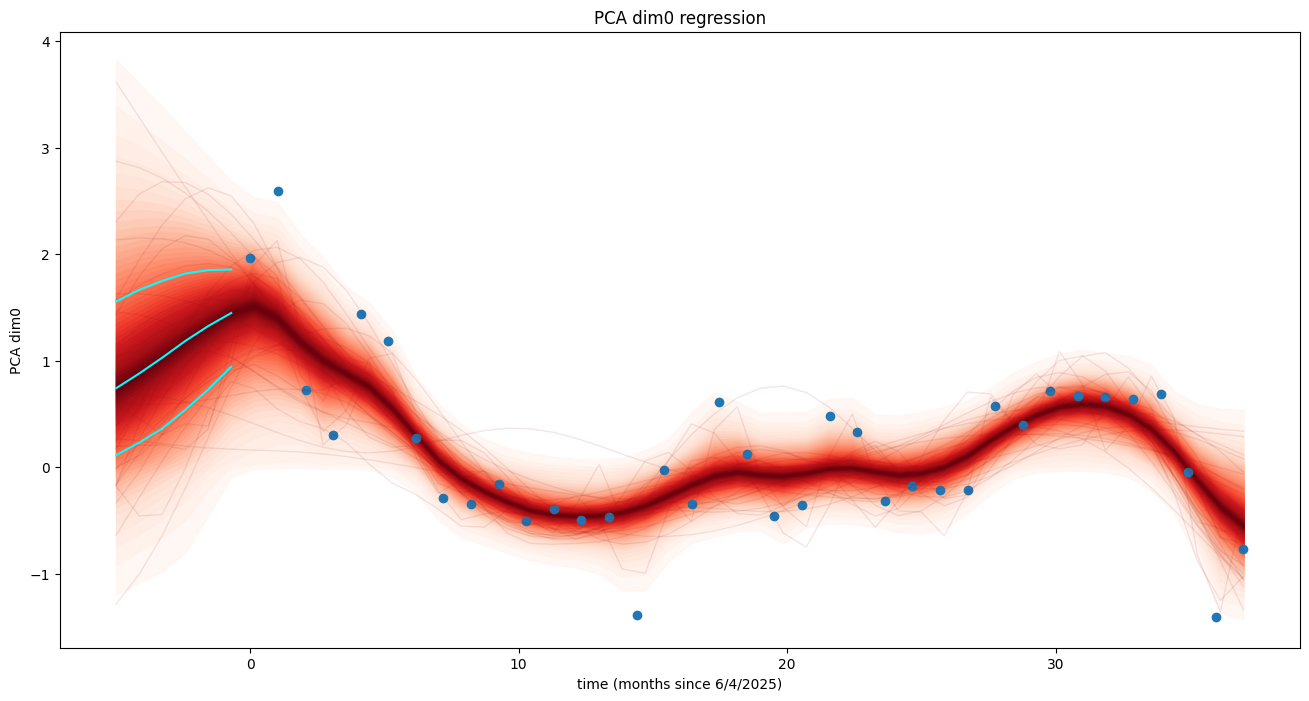

<Figure size 1600x800 with 0 Axes>

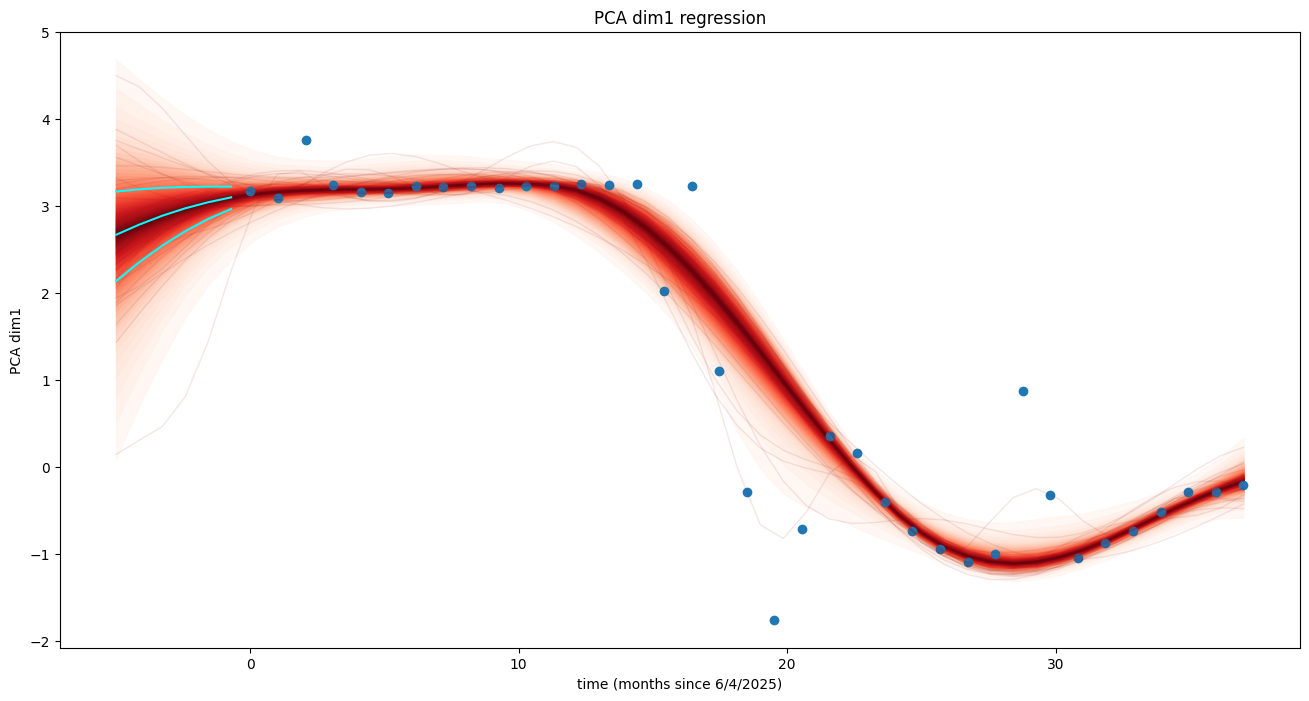

<Figure size 1600x800 with 0 Axes>

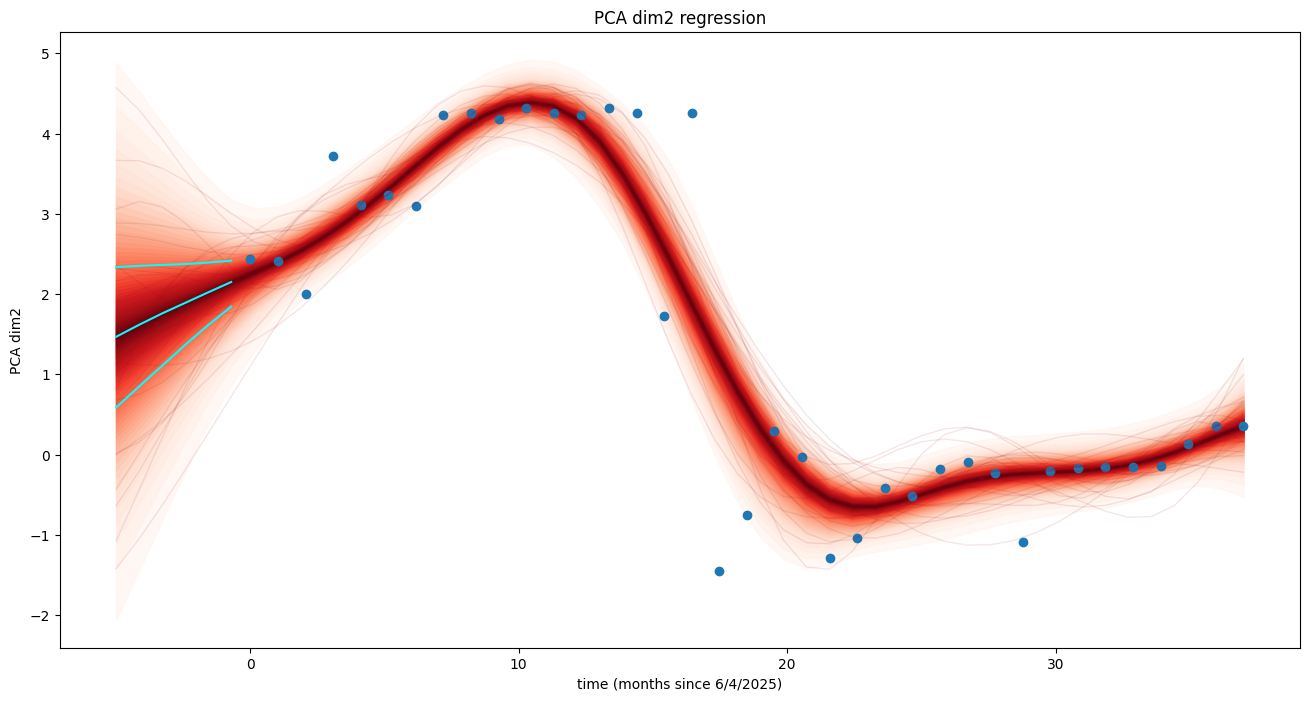

<Figure size 1600x800 with 0 Axes>

In [108]:
for i,n in enumerate(ls):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    ig = plt.figure(figsize=(16, 8))
    ax = fig.gca()
    f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)

    
    ax.set_title(f"PCA {n} regression")
    ax.set_xlabel("time (months since 6/4/2025)")
    ax.set_ylabel(f"PCA {n}")
    ax = plot_gp_dist(ax, f_pred, new_x_vals, palette="Reds")
    # f_pred = az.extract(pred_data[i].posterior_predictive, var_names="f_pred").transpose("sample", ...)
    # f_post = az.extract(idata[i], var_names="f").transpose("sample", ...)
    # reg_preds.append(f_pred)
    
    # plot_gp_dist(ax, f_post, x_vals, palette="Reds")
    for j in range(sampled_seqs.shape[2]):
        ax.plot(new_x_vals[:6], sampled_seqs[i,:,j], c="aqua")
    ax.set_title(f"PCA {n} regression")
    ax.set_xlabel("time (months since 6/4/2025)")
    ax.set_ylabel(f"PCA {n}")
    ax.scatter(x_vals, avg_coords[n])
    # ax.scatter(x_vals, avg_coords[n])
    plt.show()

reg_preds = np.array(reg_preds)

In [93]:
Z_regression_recon = vae_model.decoder.forward(torch.tensor(Z_regression_pred).float().to(DEVICE))
Z_regression_recon = torch.argmax(Z_regression_recon.view(old_shape[0], old_shape[1], -1, 5), dim=-1).cpu().detach().numpy()
old_shape = Z_regression_recon.shape

In [94]:
converter = np.vectorize(lambda x: ALPHABET[int(x)])
Z_regression_recon = converter(Z_regression_recon.ravel()).reshape(old_shape)

In [96]:
print(Z_regression_recon.shape)

(6, 3, 3822)


In [100]:
names = ["1q","2q","3q"]
for i,n in zip(range(Z_regression_recon.shape[1]), names):
    print(".",end="")
    with open(f"regression_recons_{n}.fasta","w") as f:
        for j in range(Z_regression_recon.shape[0]):
            f.write(f">RECON_{i}_{j}\n")
            f.write("".join(Z_regression_recon[j,i,:]))
            f.write("\n")
    print("done!")

.done!
.done!
.done!
